In [1]:
import sys

In [2]:
cd '/srv/flash1/hagrawal9/project/habitat/habitat-api/'

/coc/testnvme/hagrawal9/project/habitat/habitat-api


In [3]:
import gzip
import json
import os
import sys
from typing import Any, Dict, List, Optional, Type

import attr
import cv2
import git
import magnum as mn
import numpy as np

# %matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image


import habitat
import habitat_sim
from habitat.core.registry import registry
from habitat_sim.utils import viz_utils as vut
from habitat.utils.visualizations import maps
from habitat.utils.visualizations.utils import observations_to_image

In [4]:
import habitat_sim

In [5]:
from habitat.datasets.rearrangement.rearrangement_dataset import RearrangementDatasetV0
from habitat.tasks.rearrangement.rearrangement_task import RearrangementEpisode
from rearrangement.task.environment import RearrangementRLEnv

In [6]:
from rearrangement.task.sensors import *

In [7]:
from habitat_baselines.config.default import get_config
from habitat_baselines.common.utils import batch_obs

In [8]:
def print_info(obs, reward, info):
    obj_id = info['current_obj_id_navmesh']
    a2o_dist = info['agent_to_object_distance'][obj_id]
    o2g_dist = info['object_to_goal_distance'][obj_id]
    opg = obs['all_object_positions'][obj_id]
    gpg = obs['all_object_goals'][obj_id]
    opg_angle = np.rad2deg(obs['all_object_positions'][0][1])
    gpg_angle = np.rad2deg(obs['all_object_goals'][0][1])
    
    print("Reward: {}, ObjId: {}, A2O Dist: {}, O2G Dist: {} Object: {} Goal: {} Gripped ObjID: {}".format(sum(reward.values()), obj_id, a2o_dist, o2g_dist, (opg[0], opg_angle), (gpg[0], gpg_angle), obs['gripped_object_id']))

In [9]:
config = get_config("rearrangement/configs/rearrangement.yaml")

In [10]:
config.defrost()
config.TASK_CONFIG.defrost()
config.TASK_CONFIG.DATASET.SPLIT = "train"
config.TASK_CONFIG.SIMULATOR.RGB_SENSOR.WIDTH = 1024
config.TASK_CONFIG.SIMULATOR.RGB_SENSOR.HEIGHT = 1024
config.TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.WIDTH = 1024
config.TASK_CONFIG.SIMULATOR.DEPTH_SENSOR.HEIGHT = 1024
config.TASK_CONFIG.DATASET.CONTENT_SCENES = ['rearrangement_v1_train_n=1000_o=5_Helix']
config.TASK_CONFIG.TASK.MEASUREMENTS = ['OBJECT_TO_GOAL_DISTANCE', 'AGENT_TO_OBJECT_DISTANCE', 'TOP_DOWN_MAP']
config.TASK_CONFIG.freeze()
config.freeze()

In [11]:
registry.mapping['sensor']

{'HabitatSimRGBSensor': habitat.sims.habitat_simulator.habitat_simulator.HabitatSimRGBSensor,
 'HabitatSimRGBSensor3rdPerson': habitat.sims.habitat_simulator.habitat_simulator.HabitatSimRGBSensor3rdPerson,
 'HabitatSimDepthSensor': habitat.sims.habitat_simulator.habitat_simulator.HabitatSimDepthSensor,
 'HabitatSimSemanticSensor': habitat.sims.habitat_simulator.habitat_simulator.HabitatSimSemanticSensor,
 'PointGoalSensor': habitat.tasks.nav.nav.PointGoalSensor,
 'ImageGoalSensor': habitat.tasks.nav.nav.ImageGoalSensor,
 'PointGoalWithGPSCompassSensor': habitat.tasks.nav.nav.IntegratedPointGoalGPSAndCompassSensor,
 'HeadingSensor': habitat.tasks.nav.nav.HeadingSensor,
 'CompassSensor': habitat.tasks.nav.nav.EpisodicCompassSensor,
 'GPSSensor': habitat.tasks.nav.nav.EpisodicGPSSensor,
 'ProximitySensor': habitat.tasks.nav.nav.ProximitySensor,
 'QuestionSensor': habitat.tasks.eqa.eqa.QuestionSensor,
 'InstructionSensor': habitat.tasks.vln.vln.InstructionSensor,
 'GrippedObjectSensor': ha

In [12]:
try:
    env.close()
except:
    pass
env = RearrangementRLEnv(config)

2020-11-16 22:29:43,879 Initializing dataset RearrangementDataset-v0
2020-11-16 22:29:43,994 initializing sim RearrangementSim-v0


Episode Length: 0
Episode Length: 1000


I1116 22:29:49.703557 29060 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Helix.navmesh
I1116 22:29:49.706315 29060 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.
2020-11-16 22:29:49,871 Initializing task RearrangementTask-v0


Success Dist: 0.25
Next Object Sensor: oracle_next_object


In [61]:
config.TASK_CONFIG.TASK.SENSORS

['GRIPPED_OBJECT_SENSOR',
 'ALL_OBJECT_POSITIONS',
 'ALL_OBJECT_GOALS',
 'ORACLE_NEXT_OBJECT_SENSOR',
 'RANDOM_OBJECT_SENSOR',
 'CLOSEST_OBJECT_SENSOR',
 'L2DIST_OBJECT_SENSOR']

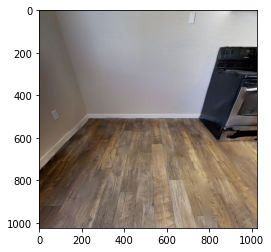

In [82]:
obs = env.reset()
content_scenes_path_list = []
plt.imshow(obs['rgb'])

In [91]:
obs = env.step(action={'action': 2})

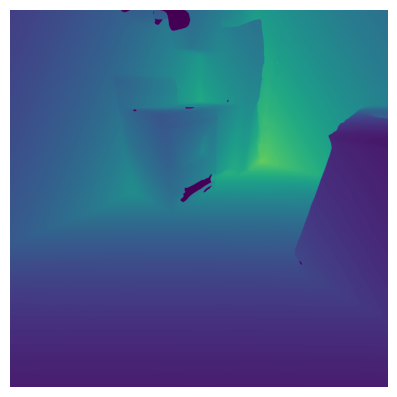

In [95]:
plt.figure(figsize=(5,5), dpi=100)
plt.axis('off')
plt.imshow(obs[0]['depth'].reshape(1024, 1024))
plt.savefig('teaser_depth.png')

In [28]:
import torch
import torch.nn as nn

In [53]:
goal_embedding = nn.Linear(3, 3)
pos_embedding = nn.Linear(3, 3)

In [54]:
bo = batch_obs([obs])

In [55]:
bo['all_object_goals']

tensor([[[ 2.4193,  2.5869],
         [ 2.4709,  1.6085],
         [ 5.4662, -1.5091],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]]])

In [56]:
nenvs, nobjs = bo['all_object_positions'].shape[0:2]

In [60]:
op = bo['all_object_positions'].reshape(nenvs * nobjs, -1)
gp = bo['all_object_goals'].reshape(nenvs * nobjs, -1)
op = torch.stack(
    [
        op[:, 0],
        torch.cos(-op[:, 1]),
        torch.sin(-op[:, 1])
    ], -1
)
gop = goal_embedding(op).reshape(nenvs, nobjs, -1)

In [65]:
gop = gop.reshape(nenvs , -1)

In [62]:
gop

tensor([[[-3.0896,  3.2774,  3.5084],
         [-3.9045,  4.4328,  4.5676],
         [-3.2982,  3.1142,  3.3073],
         [ 0.2547,  0.1203, -0.2451],
         [ 0.2547,  0.1203, -0.2451]]], grad_fn=<ViewBackward>)

In [66]:
gop

tensor([[-3.0896,  3.2774,  3.5084, -3.9045,  4.4328,  4.5676, -3.2982,  3.1142,
          3.3073,  0.2547,  0.1203, -0.2451,  0.2547,  0.1203, -0.2451]],
       grad_fn=<ViewBackward>)

Reward: -0.23875319957733154, ObjId: 1, A2O Dist: 0.0, O2G Dist: 0.9737892150878906 Object: (0.0, -130.8933081220175) Goal: (0.9679238796234131, -7.492691052520954) Gripped ObjID: 1


(array([[ 2.0275507 , -0.13077213],
        [ 0.96792388, -2.90506721],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]]),
 array([[ 2.36627102, -2.2845192 ],
        [ 0.        ,  3.14159274],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]]),
 array([ 1.        ,  0.        ,  3.14159274,  0.96792388, -2.90506721]))

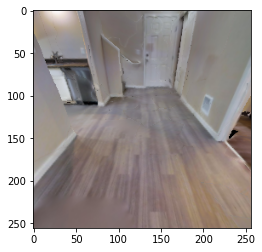

In [334]:
obs, reward, done, info = env.step(action={'action':0})
plt.imshow(obs['rgb'])
print_info(obs, reward, info)
obs['all_object_goals'], obs['all_object_positions'], obs['oracle_next_object']

Reward: 0.0, ObjId: 1, A2O Dist: 0.0, O2G Dist: 0.9737892150878906 Object: (0.0, 49.10670371712803) Goal: (0.9679238796234131, 172.50731481020904) Gripped ObjID: 1


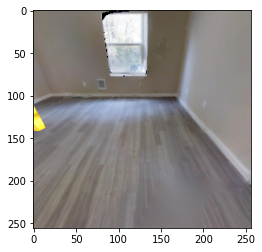

In [354]:
obs, reward, done, info = env.step(action={'action':1})
plt.imshow(obs['rgb'])
print_info(obs, reward, info)

Reward: 0.0, ObjId: 1, A2O Dist: 0.0, O2G Dist: 0.5072381496429443 Object: (0.0, -120.39142782025931) Goal: (0.4958847463130951, -6.0125374060735925) Gripped ObjID: 1


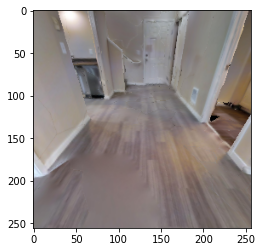

In [330]:
obs, reward, done, info = env.step(action={'action':2})
plt.imshow(obs['rgb'])
print_info(obs, reward, info)

Reward: 2.4, ObjId: 0, A2O Dist: 2.3662712574005127, O2G Dist: 3.8970351219177246 Object: (2.3662710189819336, 49.10670371712803) Goal: (2.02755069732666, 172.50731481020904) Gripped ObjID: -1


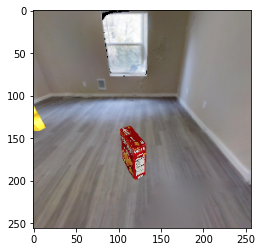

In [355]:
obs, reward, done, info = env.step(action={'action':3})
plt.imshow(obs['rgb'])
print_info(obs, reward, info)

In [102]:
obs['gripped_object_id']

3

In [43]:
info.keys()

dict_keys(['object_to_goal_distance', 'agent_to_object_distance', 'top_down_map', 'episode_success', 'objs_success', 'episode_mean_dist', 'episode_length', 'no_of_objects', 'pickup_order_navmesh', 'current_obj_id_navmesh', 'pickup_order_random', 'current_obj_id_random', 'pickup_order_closest', 'current_obj_id_closest', 'pickup_order_l2dist', 'current_obj_id_l2dist'])